# Acidentes de Trânsito em Santa Catarina

# 0- Setup e Carregamento do Conjunto de Dados

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [81]:
def show_descriptive_statistics(df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean))
    ct2 = pd.DataFrame(df.apply(np.median))    

    # Dispersion - std, min, max, range
    d1 = pd.DataFrame(df.apply(np.std))
    d2 = pd.DataFrame(df.apply(min))
    d3 = pd.DataFrame(df.apply(max))
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min()))    

    m = pd.concat([d2, d3, d4, ct1, ct2, d1], axis = 1).reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std']    
    return m

In [3]:
# carregando o dataset raw e selecionando os datapoints de SC

current_path = os.getcwd()
acidentes_raw = pd.read_csv(current_path.replace('/notebooks', '') + '/data/raw/acidentes2023.csv', sep=';', encoding = "ISO-8859-1")
acidentes_sc_raw = acidentes_raw.loc[acidentes_raw['uf'] == 'SC']

In [4]:
# fazendo uma cópia e salvando um csv da parte selecionada do dataframe acima

acidentes_sc_1 = acidentes_sc_raw.copy()
acidentes_sc_1.reset_index(inplace=True)
acidentes_sc_1.to_csv(current_path.replace('/notebooks', '') + '/data/interim/acidentes_sc_1.csv')

# 1- Seleção e Criação de Variáveis

Lista de variáveis a serem analisadas:

- dia_semana;
- horario;
- causa_acidente;
- municipio;
- mortos;
- tipo_veiculo.

Também criaremos variáveis para análise:
- número de acidentes por município;
- número de acidentes por dia da semana e horário.

In [5]:
# selecionando as colunas que serão utilizadas e salvando em um arquivo csv separado

colunas_selecionadas = ['dia_semana', 'horario', 'mortos', 'causa_acidente', 'municipio', 'tipo_veiculo']
acidentes_sc_colunas_selecionadas = acidentes_sc_1[colunas_selecionadas].copy()
acidentes_sc_colunas_selecionadas.to_csv(current_path.replace('/notebooks', '') + '/data/interim/acidentes_sc_colunas_selecionadas.csv')

In [6]:
# fazendo um novo dataframe de número de acidentes por município

values = acidentes_sc_colunas_selecionadas['municipio'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['municipio'].value_counts().tolist()
municipios_se = pd.Series(values, name='municipio')
numero_acidentes_municipio_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_municipio = pd.concat([municipios_se, numero_acidentes_municipio_se], axis=1)

In [7]:
# criando uma coluna somente com o valor de hora do horário

acidentes_sc_colunas_selecionadas['hora'] = acidentes_sc_colunas_selecionadas['horario'].map(lambda x: x[0:2])

In [8]:
# criando um dataframe com o número de acidentes por faixa de horário

values = acidentes_sc_colunas_selecionadas['hora'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['hora'].value_counts().tolist()
horario_se = pd.Series(values, name='hora')
numero_acidentes_horario_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_horario = pd.concat([horario_se, numero_acidentes_horario_se], axis=1)

In [9]:
# criando uma coluna com os dias da semana codificados numericamente

dias_da_semana = {
    "domingo": 0,
    "segunda-feira": 1,
    "terça-feira": 2,
    "quarta-feira": 3,
    "quinta-feira": 4,
    "sexta-feira": 5,
    "sábado": 6
}

acidentes_sc_colunas_selecionadas['dia_semana_codificado'] = acidentes_sc_colunas_selecionadas['dia_semana'].map(dias_da_semana)

In [10]:
# criando um data frame com o número de acidentes por dia da semana

values = acidentes_sc_colunas_selecionadas['dia_semana'].value_counts().keys().tolist()
counts = acidentes_sc_colunas_selecionadas['dia_semana'].value_counts().tolist()
dia_semana_se = pd.Series(values, name='dia_semana')
numero_acidentes_dia_semana_se = pd.Series(counts, name='numero_acidentes')
numero_acidentes_por_dia_semana = pd.concat([dia_semana_se, numero_acidentes_dia_semana_se], axis=1)

In [12]:
numero_acidentes_por_municipio

,municipio,numero_acidentes
0,SAO JOSE,1658
1,PALHOCA,1346
2,ITAJAI,880
3,BALNEARIO CAMBORIU,726
4,JOINVILLE,682
...,...,...
113,FLOR DO SERTAO,4
114,TREZE DE MAIO,3
115,BALNEARIO BARRA DO SUL,2
116,SALETE,1


In [13]:
numero_acidentes_por_horario

,hora,numero_acidentes
0,18,1548
1,17,1323
2,19,1241
3,16,1172
4,07,1137
5,14,983
6,11,963
7,15,959
8,08,946
9,12,911


In [14]:
numero_acidentes_por_dia_semana

,dia_semana,numero_acidentes
0,sábado,3353
1,sexta-feira,3200
2,domingo,3175
3,segunda-feira,2634
4,quinta-feira,2548
5,quarta-feira,2482
6,terça-feira,2294


# 2- Gráficos Univariados

## 2.1 Causas Acidentes (top10 mais frequentes)

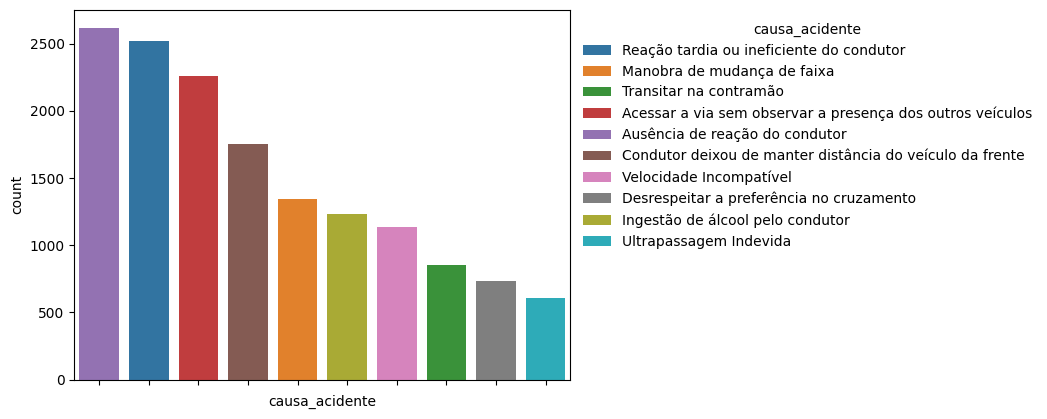

In [15]:
# selecionando as 10 causas mais frequentes e selecionando os datapoints associados

causas = acidentes_sc_colunas_selecionadas['causa_acidente'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['causa_acidente'].isin(causas)]
plot = sns.countplot(data=data, x='causa_acidente', order=causas, hue='causa_acidente', legend=True)
plot.set(xticklabels=[])
sns.move_legend(plot, 'best', ncol=1, bbox_to_anchor=(1, 1), frameon=False)

## 2.2 Tipo Veículos (top10 mais frequentes)

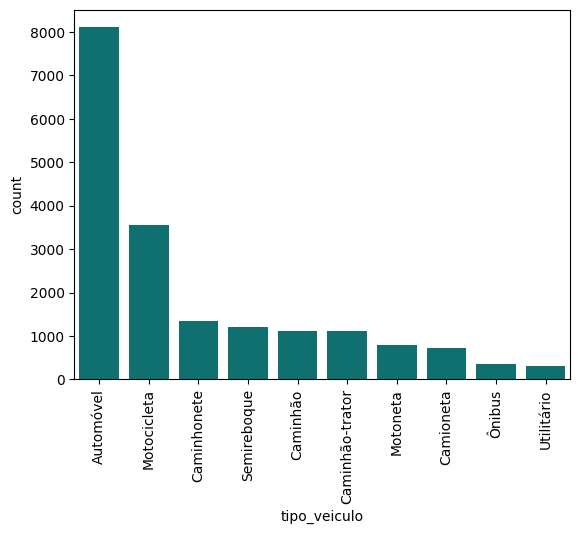

In [31]:
# selecionando os 10 mais frequentes e selecionando os datapoints associados

veiculos = acidentes_sc_colunas_selecionadas['tipo_veiculo'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['tipo_veiculo'].isin(veiculos)]
plot = sns.countplot(data=data, x='tipo_veiculo', order=veiculos, color='teal')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 2.3 Município (top10 com mais acidentes)

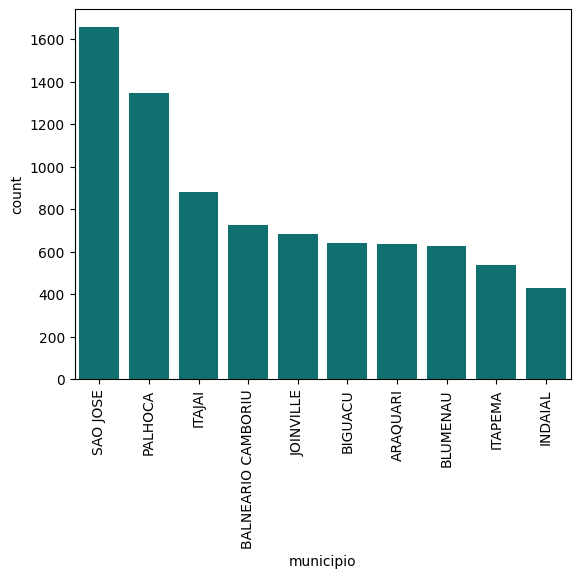

In [32]:
# selecionando os 10 mais frequentes e selecionando os datapoints associados

municipios = acidentes_sc_colunas_selecionadas['municipio'].value_counts().keys().tolist()[0:10]
data = acidentes_sc_colunas_selecionadas.loc[acidentes_sc_colunas_selecionadas['municipio'].isin(municipios)]
plot = sns.countplot(data=data, x='municipio', order=municipios, color='teal')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 2.4 Acidentes Fatais

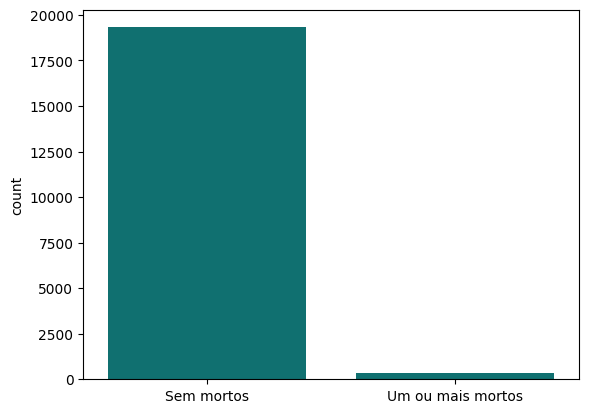

In [68]:
plot = sns.countplot(data=acidentes_sc_colunas_selecionadas, x='mortos', color='teal', legend=True)
a = plot.set(xticklabels=['Sem mortos', 'Um ou mais mortos'])
a = plot.set(xlabel=None)
#plot.set_yscale('log')

No ano passado, em SC, a porcentagem de acidentes fatais em relação ao número total de acidentes foi 1,85%.

## 2.5 Número de Acidentes por Hora e Dia da Semana

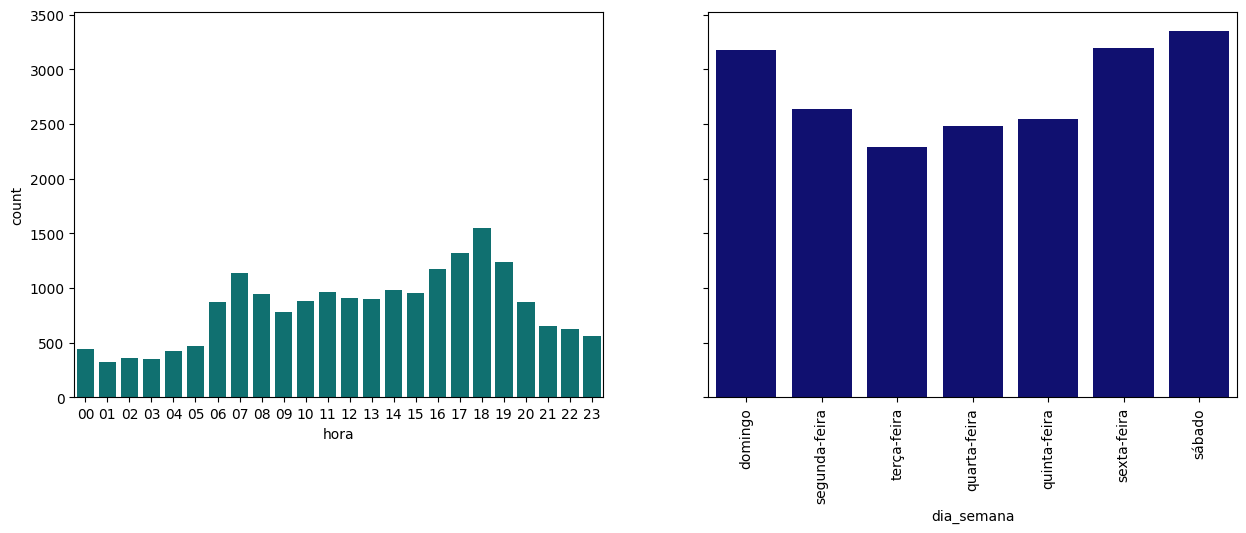

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharey = 'row',figsize = (15, 5))

sns.countplot(data=acidentes_sc_colunas_selecionadas.sort_values(by='hora'), x='hora', ax=ax0, color='teal')
sns.countplot(data=acidentes_sc_colunas_selecionadas.sort_values(by='dia_semana_codificado'), x='dia_semana', ax=ax1, color='navy')
locs, labels = plt.xticks()
a = plt.setp(labels, rotation=90)

## 2.6 Boxplots das Variáveis Numéricas 

Abaixo, calculamos algumas métricas e plotaremos gráficos de caixa para as seguintes variáveis:
- Número de Acidentes por Município;
- Número de Acidentes por Horário;
- Número de Acidentes por Dia da Semana.

### 2.6.1 Número de Acidentes por Município

In [77]:
num_attributes = numero_acidentes_por_municipio.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,1,1658,1657,166.830508,90.5,239.7105


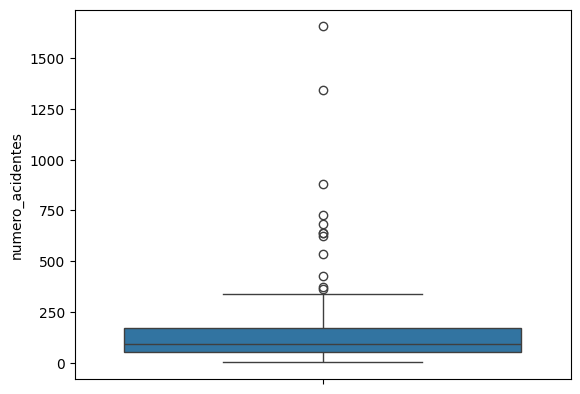

In [74]:
plot = sns.boxplot(data=numero_acidentes_por_municipio, y='numero_acidentes')

### 2.6.2 Número de Acidentes por Horário

In [78]:
num_attributes = numero_acidentes_por_horario.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,320,1548,1228,820.25,880.0,324.920792


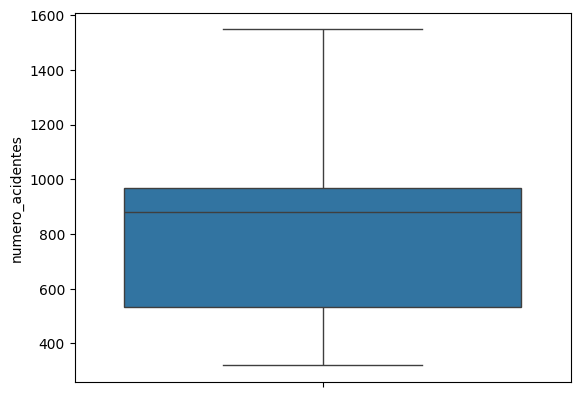

In [75]:
plot = sns.boxplot(data=numero_acidentes_por_horario, y='numero_acidentes')

### 2.6.3 Número de Acidentes por Dia da Semana

In [80]:
num_attributes = numero_acidentes_por_dia_semana.select_dtypes(include=['int64'])
moments_table = show_descriptive_statistics(num_attributes)
moments_table

,attributes,min,max,range,mean,median,std
0,numero_acidentes,2294,3353,1059,2812.285714,2634.0,387.961233


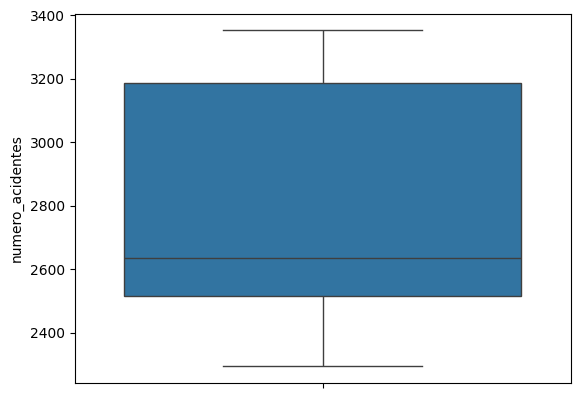

In [79]:
plot = sns.boxplot(data=numero_acidentes_por_dia_semana, y='numero_acidentes')